In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import torch

from sda.mcs import *
from sda.score import *
from sda.utils import *

from utils import *

chain = make_chain()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Score network

In [2]:
# score = load_score(PATH / 'runs/glorious-flower-3_zw7vkqm0/state.pth')  # k=1, width=32
# score = load_score(PATH / 'runs/azure-wave-2_9ry6v9ul/state.pth')  # k=1, width=64
# score = load_score(PATH / 'runs/bumbling-monkey-6_3m4uyfe8/state.pth')  # k=1, width=96
score = load_score(PATH / 'runs/graceful-snowball-8_i6pzpnst/state.pth')  # k=2, width=96

## Circle

In [3]:
def circle():
    x = torch.linspace(-1, 1, 64)
    x = torch.cartesian_prod(x, x)

    dist = x.square().sum(dim=-1).reshape(64, 64)
    mask = torch.logical_and(0.4 < dist, dist < 0.6)

    return mask

mask = circle().cuda()

def A(x):
    return chain.vorticity(x[..., -1, :, :, :]) * mask

sde = VPSDE(
    GaussianScore(
        y=0.6 * mask,
        A=A,
        std=0.2,
        sde=VPSDE(score, shape=()),
    ),
    shape=(8, 2, 64, 64),
).cuda()

100%|██████████| 256/256 [00:18<00:00, 13.54it/s]


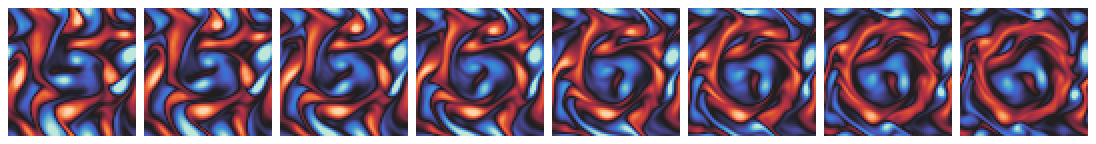

In [4]:
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_circle.png')
draw(w, zoom=4)

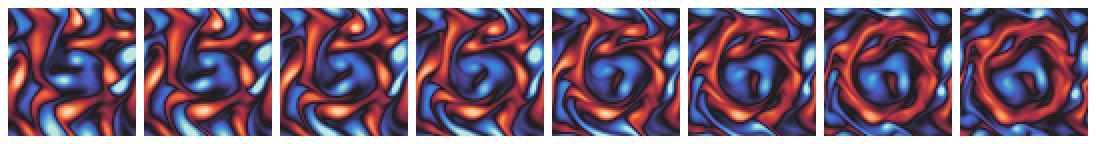

In [5]:
y0 = chain.upsample(x[0], 4)
y = chain.trajectory(y0, length=7)
y = torch.cat((y0[None], y))
y = chain.coarsen(y, 4)

w = chain.vorticity(y)

draw(w, zoom=4).save('x_circle_sim.png')
draw(w, zoom=4)

## Assimilation

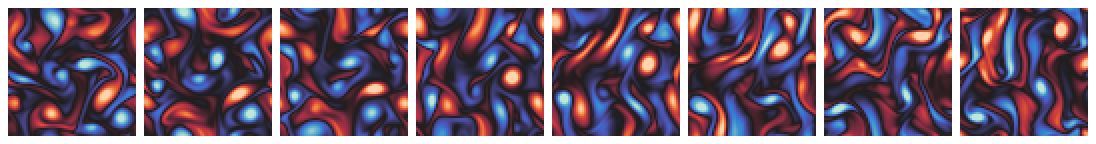

In [6]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][1, :29])

w = chain.vorticity(x_star[::4])

draw(w, zoom=4).save('x_star_assim.png')
draw(w, zoom=4)

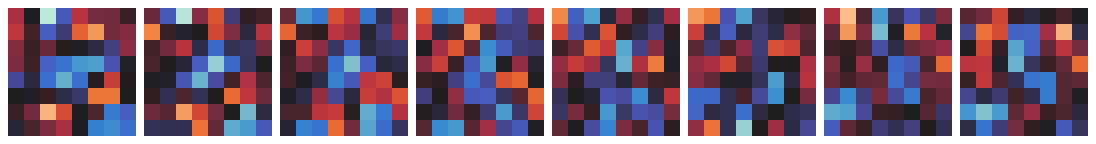

In [7]:
def A(x):
    return chain.coarsen(x[..., ::4, :, :, :], 8)

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(y_star) / 2.5
w = chain.upsample(w, 2, mode='nearest')

draw(w, pad=1, zoom=16).save('y_star_assim.png')
draw(w, pad=1, zoom=16)

100%|██████████| 256/256 [01:20<00:00,  3.16it/s]


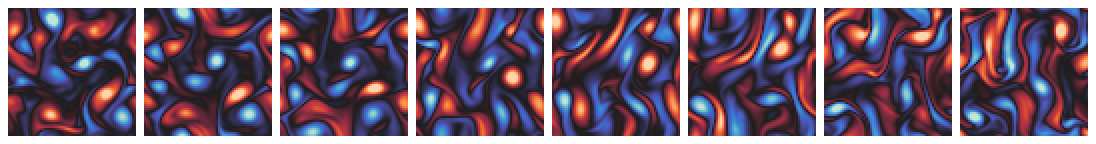

In [8]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::4])

draw(w, zoom=4).save('x_sda_assim.png')
draw(w, zoom=4)

In [9]:
(A(x) - y_star).std()  # should be ≈ 0.1

tensor(0.1101)

100%|██████████| 256/256 [01:21<00:00,  3.15it/s]


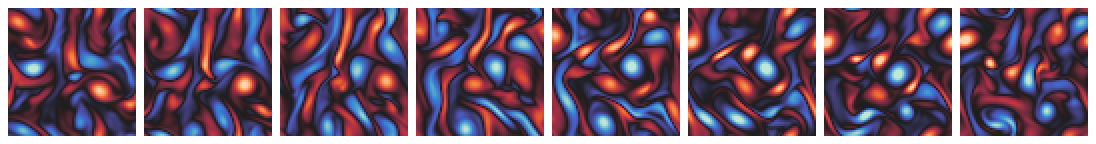

In [10]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::4])

draw(w, zoom=4).save('x_dps_assim.png')
draw(w, zoom=4)

In [11]:
(A(x) - y_star).std()

tensor(0.8573)

## Extrapolation

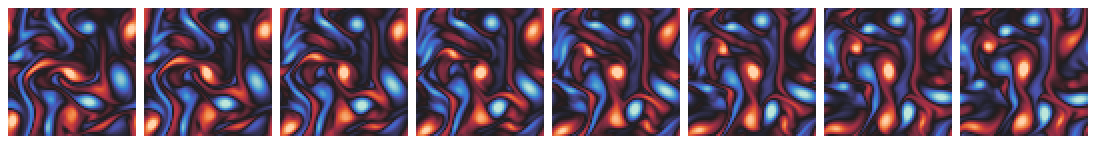

In [12]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][0, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_extra.png')
draw(w, zoom=4)

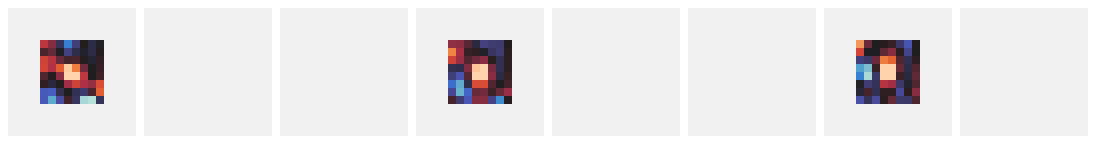

In [13]:
def A(x):
    return chain.coarsen(x, 4)[..., ::3, :, 4:12, 4:12]

y_star = torch.normal(A(x_star), 0.01)

w = chain.vorticity(chain.coarsen(x_star, 4)) / 2

mask = np.zeros((8, 16, 16), dtype=bool)
mask[::3, 4:12, 4:12] = True

draw(w, mask, pad=1, zoom=16).save('y_star_extra.png')
draw(w, mask, pad=1, zoom=16)

100%|██████████| 256/256 [00:16<00:00, 15.35it/s]


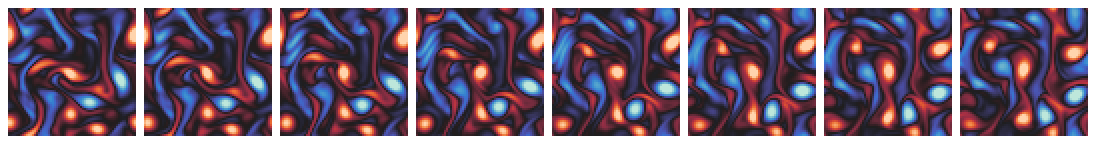

In [14]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.01,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_extra.png')
draw(w, zoom=4)

In [15]:
(A(x) - y_star).std()  # should be ≈ 0.01

tensor(0.0179)

100%|██████████| 256/256 [00:16<00:00, 15.36it/s]


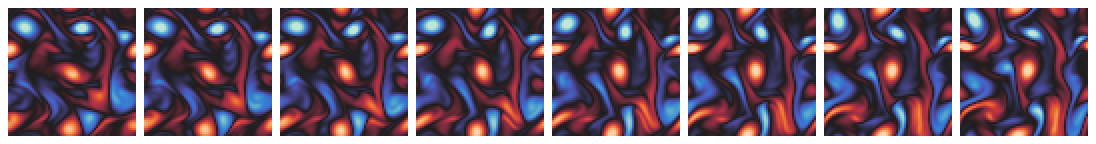

In [16]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_extra.png')
draw(w, zoom=4)

In [17]:
(A(x) - y_star).std()

tensor(0.4928)

## Non-linear observation process

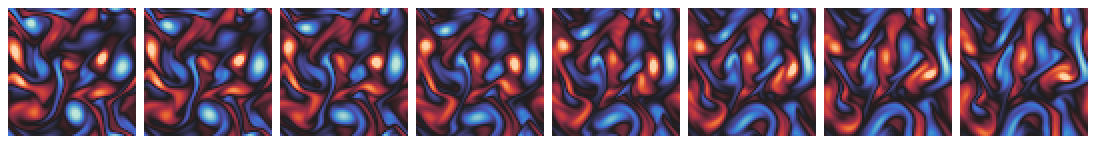

In [18]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][2, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_saturation.png')
draw(w, zoom=4)

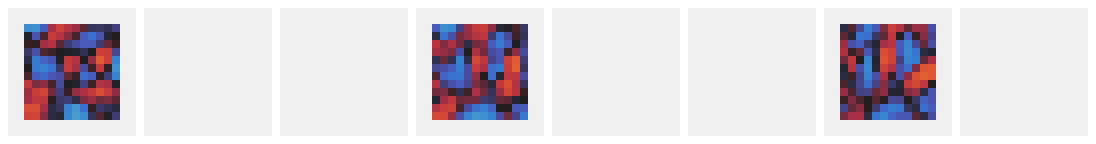

In [19]:
def A(x):
    x = chain.coarsen(x[..., ::3, :, :, :], 4)
    w = chain.vorticity(x)
    w = w / (1 + abs(w))

    return w[..., 2:14, 2:14]

y_star = torch.normal(A(x_star), 0.05)

w = chain.vorticity(chain.coarsen(x_star, 4))
w = w / (1 + abs(w))

mask = np.zeros((8, 16, 16), dtype=bool)
mask[::3, 2:14, 2:14] = True

draw(w, mask, pad=1, zoom=16).save('y_star_saturation.png')
draw(w, mask, pad=1, zoom=16)

100%|██████████| 512/512 [00:34<00:00, 14.87it/s]


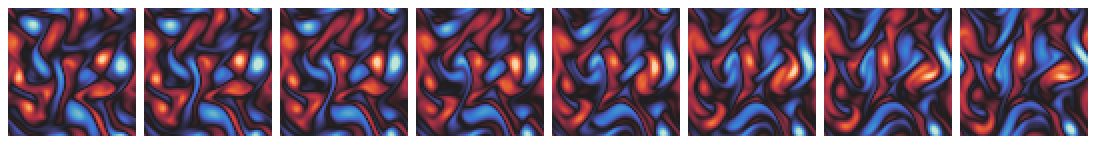

In [20]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.05,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=512, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_saturation.png')
draw(w, zoom=4)

In [21]:
(A(x) - y_star).std()

tensor(0.0610)

100%|██████████| 512/512 [00:34<00:00, 14.83it/s]


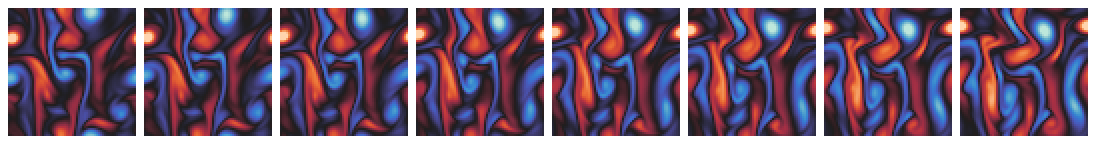

In [22]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=512, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_saturation.png')
draw(w, zoom=4)

In [23]:
(A(x) - y_star).std()

tensor(0.5483)

## Subsampling

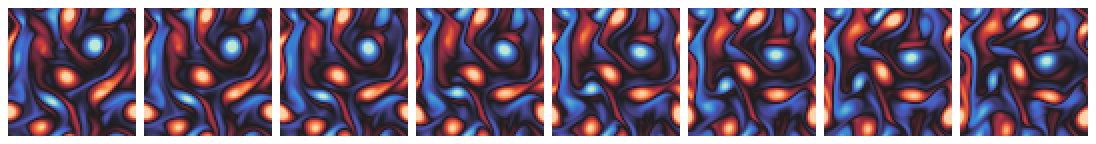

In [24]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][3, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_sub.png')
draw(w, zoom=4)

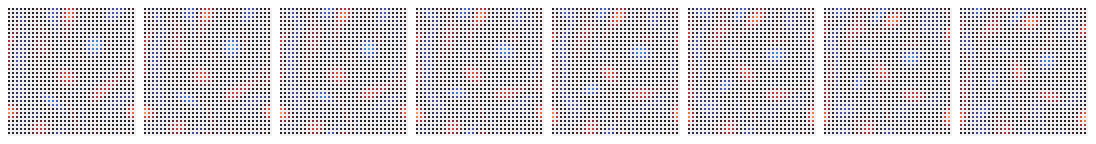

In [25]:
def A(x):
    return x[..., ::2, ::2]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::2, ::2] = True

draw(w, mask, zoom=4).save('y_star_sub_2.png')
draw(w, mask, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.35it/s]


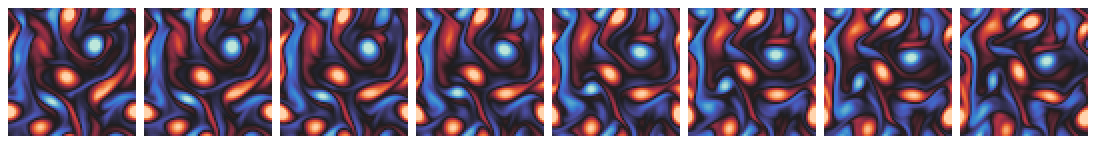

In [26]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_2.png')
draw(w, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.17it/s]


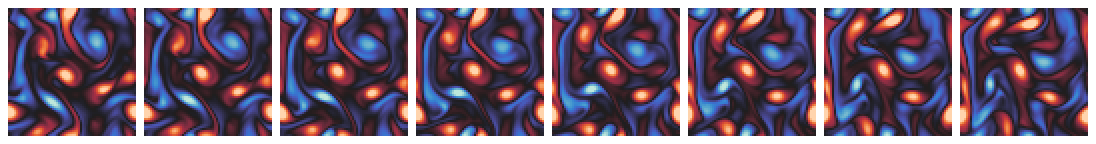

In [27]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_2.png')
draw(w, zoom=4)

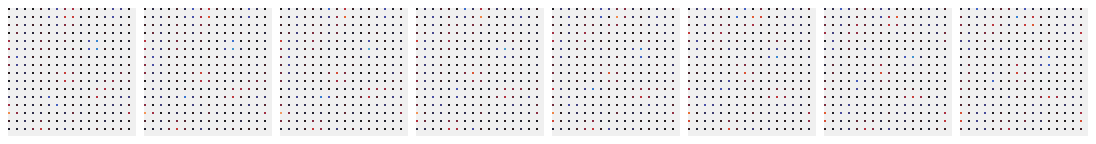

In [28]:
def A(x):
    return x[..., ::4, ::4]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::4, ::4] = True

draw(w, mask, zoom=4).save('y_star_sub_4.png')
draw(w, mask, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.29it/s]


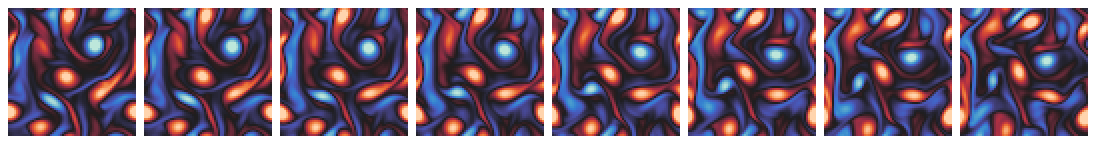

In [29]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_4.png')
draw(w, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.42it/s]


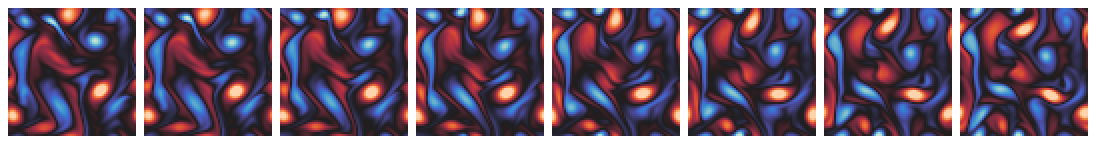

In [30]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_4.png')
draw(w, zoom=4)

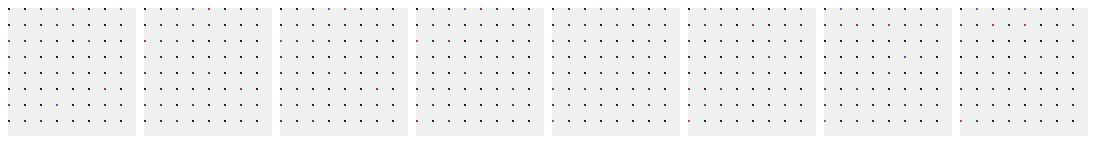

In [31]:
def A(x):
    return x[..., ::8, ::8]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::8, ::8] = True

draw(w, mask, zoom=4).save('y_star_sub_8.png')
draw(w, mask, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.21it/s]


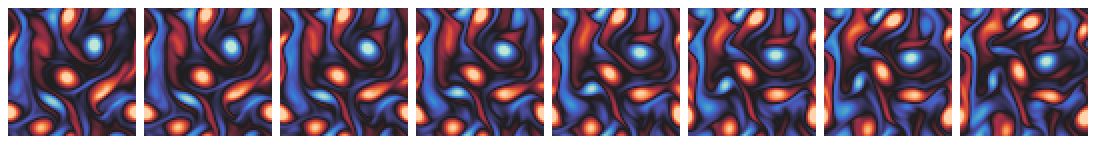

In [32]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_8.png')
draw(w, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.10it/s]


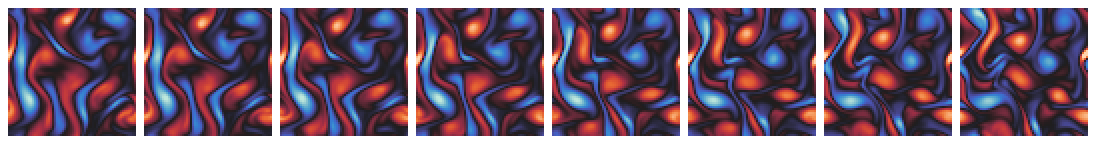

In [33]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_8.png')
draw(w, zoom=4)

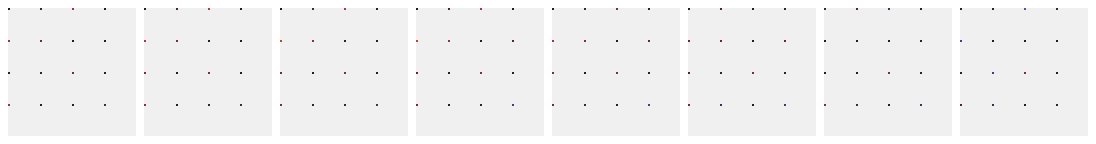

In [34]:
def A(x):
    return x[..., ::16, ::16]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::16, ::16] = True

draw(w, mask, zoom=4).save('y_star_sub_16.png')
draw(w, mask, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.26it/s]


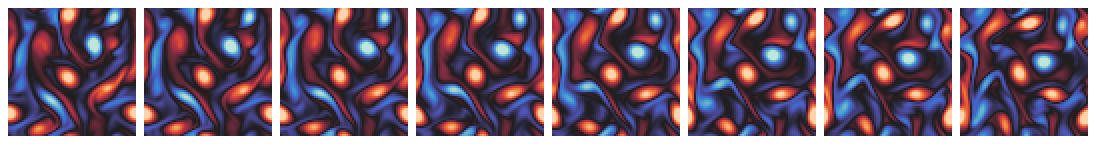

In [35]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_16.png')
draw(w, zoom=4)

100%|██████████| 256/256 [00:16<00:00, 15.27it/s]


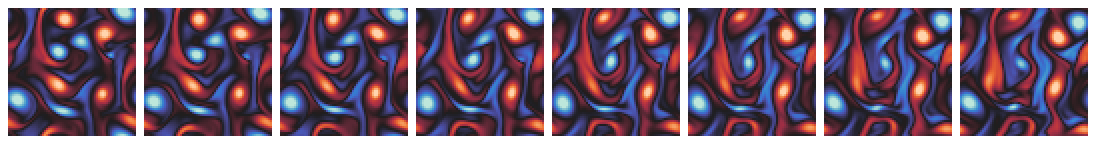

In [36]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_16.png')
draw(w, zoom=4)

## Loop

100%|██████████| 256/256 [06:19<00:00,  1.48s/it]


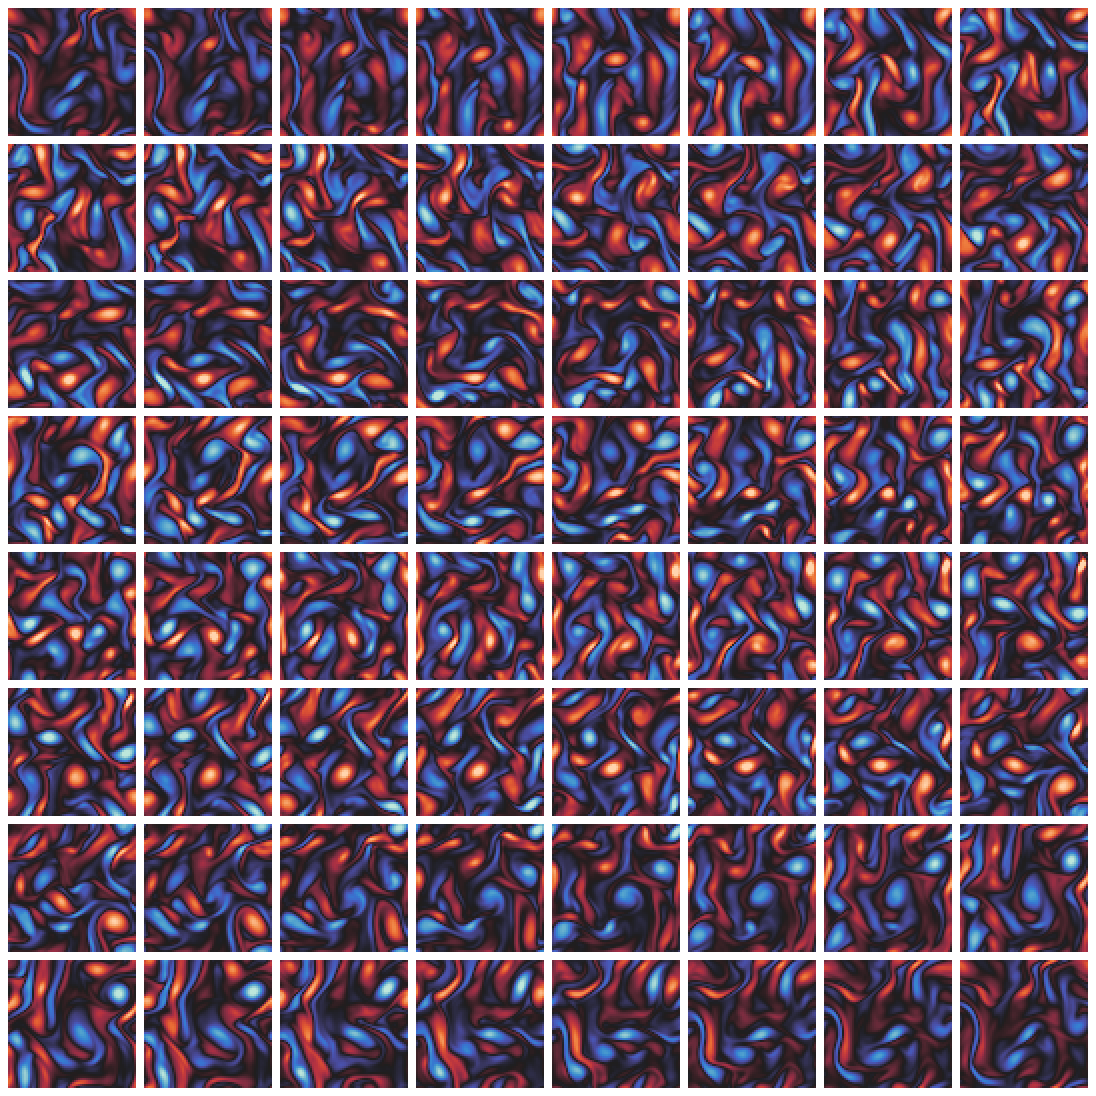

In [37]:
sde = VPSDE(
    GaussianScore(
        torch.zeros(2, 64, 64),
        A=lambda x: x[:, 0] - x[:, -1],
        std=0.01,
        sde=VPSDE(score, shape=()),
        gamma=0.1,
    ),
    shape=(127, 2, 64, 64),
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::2])

draw(w.reshape(8, 8, 64, 64), zoom=4).save('x_loop.png')
draw(w.reshape(8, 8, 64, 64), zoom=4)